# **Chapter 26**  
**┗ 통신사 이탈 고객 예측**
---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
* 🥉Session 1 - 「우량 고객 탐색」
* 🥈Session 2 - 「이탈 고객 특성 분석」
* 🥇Session 3 - 「ML 활용 이탈 고객 예측」

In [ ]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/part3_lecture_fastcampus/chapter26')
# '/content/drive/MyDrive/Colab Notebooks/ ← 여기 경로까지는 본인의 경로 입력, part3_lecture_fastcampus/chapter26' ← 변경X
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/Colab Notebooks/part3_lecture_fastcampus/chapter26'

## **문제상황 및 데이터 살펴보기**
---
> **시나리오** 📞 (마케터,  서비스 기획자)

```
A통신사는 업계 1위의 통신사였으나 그 명성이 무색해져가고 있다. 다양한 경쟁사가 등장함에 따라 M/S가 떨어지고 있고, 타 통신사로의 이탈 고객이  
증가하고 있는 상황이다. 이에 이탈 가능성이 높은 고객을 예측하고, 해지 방어 활동들을 전개하려고 한다.

```  

> **데이터 살펴보기**

* 통신사 고객 프로필 데이터
* 데이터 명세 ⬇

|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|
|:---:|:---:|:---:|:---:|:---:|:---:|
|고객ID|성별|노인여부|결혼여부|부양가족여부|회원개월수|
|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|  
|전화서비스 여부|다회선 여부|인터넷 서비스 공급자|온라인 보안 여부|온라인 백업 여부|기기보험여부|
|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|  
|기술지원여부|스트리밍TV여부|스트리밍영화여부|계약기간|종이없는청구여부|결제수단|
|MonthlyCharges|TotalCharges|Churn|
|월청구금액|청구된 총 금액|이탈여부|


In [ ]:
# ▶ Data read
import pandas as pd 
df = pd.read_csv('chapter26_telco_customer.csv')
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



## **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ 고객 이탈
```  

> **기대효과**

```
▶ 고객 이탈 방어
```

> **해결방안**

```
▶ 이탈 가능성 높은 고객 예측 및 해지 방어
▶ Session 1 🥉
 - Data 전처리 및 우량 고객 특성 파악
▶ Session 2 🥈
 - 카테고리별 이탈 고객 분석
▶ Session 3 🥇
 - ML 알고리즘을 활용하여 이탈 고객 예측
```

> **성과측정**  

```
▶ 이탈 가능성 높은 고객에 대해 관리 전/후 이탈률 모니터링
```

> **현업적용**  

```
▶ Model에 Input하기 위한 Data mart 생성
▶ 예측 모델 활용 타겟 추출 및 관리 프로그램 운영
```

> **주요 코드 미리 살펴보기**  

```
▶ session 1 → catplot, groupby.agg()
▶ session 2 → catplot, groupby.agg()
▶ session 3 → RandomForestClassifier(), LabelEncoder(), roc_auc_score, roc_curve
```

## **🥉Session 1**  
**┗ 우량 고객 탐색**  
---

### · Data 전처리  
---
* 수집된 데이터의 기본 정보들을 확인  

  (1) Data shape(형태) 확인 

  (2) Data type 확인

  (3) Null값 확인 (※ 빈 값의 Data)

  (4) Outlier 확인 (※ 정상적인 범주를 벗어난 Data)  


In [ ]:
# ▶ Data 형태 확인
# ▶ 7,043 row, 21 col로 구성됨
print('df', df.shape)

df (7043, 21)


In [ ]:
# ▶ Data type 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
# ▶ Null 값 확인
print(df.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [ ]:
# ▶ Outlier 확인
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


### · 우량고객 탐색 
---



In [ ]:
# ▶ 우량고객이라 함은 이탈률이 낮은 고객군
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [ ]:
# ▶ 약 27%의 이탈률
1869 / (1869 + 5174)

0.2653698707936959

In [ ]:
# ▶ Target 숫자 데이터로 변환
import numpy as np
df['Churn'] = np.where(df['Churn'] == 'Yes', 1, 0)
df['Churn'].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

#### · (1) 장기회원 
---



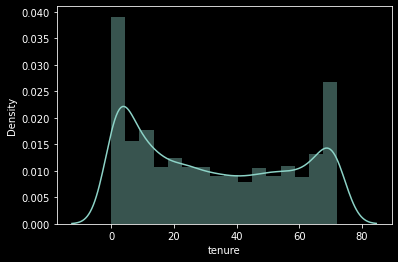

In [ ]:
# ▶ 가설1) 장기고객일수록 이탈률이 낮을 것이다.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

sns.distplot(df['tenure']);

In [ ]:
# ▶ 구간화
import numpy as np
df['tenure_gp'] = np.where (df['tenure'] <= 20, '20 이하', 
                           np.where(df['tenure'] <= 60, '20-60 이하', '60 초과'))

df[['tenure','tenure_gp']].head(5)

,tenure,tenure_gp
0,1,20 이하
1,34,20-60 이하
2,2,20 이하
3,45,20-60 이하
4,2,20 이하


In [ ]:
# ▶ 장기고객일 수록 우수고객이다.
df_gp = df.groupby('tenure_gp')['Churn'].agg(['count','sum'])
df_gp['ratio'] = round((df_gp['sum'] / df_gp['count']) * 100, 1)
df_gp['lift'] = round(df_gp['ratio'] / 27,1)
df_gp

,count,sum,ratio,lift
tenure_gp,,,,
20 이하,2878,1251,43.5,1.6
20-60 이하,2758,525,19.0,0.7
60 초과,1407,93,6.6,0.2


#### · (2) 프리미엄 요금 회원 
---



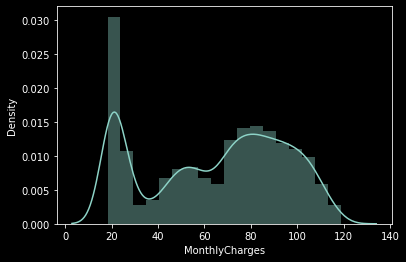

In [ ]:
# ▶ 프리미엄 요금 회원일 수록 우수고객이다.
sns.distplot(df['MonthlyCharges']);

In [ ]:
# ▶ 구간화
import numpy as np
df['MonthlyCharges_gp'] = np.where (df['MonthlyCharges'] <= 40, '40 이하', 
                           np.where(df['MonthlyCharges'] <= 80, '40-80 이하', '80 초과'))

df[['MonthlyCharges','MonthlyCharges_gp']].head(5)

,MonthlyCharges,MonthlyCharges_gp
0,29.85,40 이하
1,56.95,40-80 이하
2,53.85,40-80 이하
3,42.30,40-80 이하
4,70.70,40-80 이하


In [ ]:
# ▶ 프리미엄 요금 회원들이 이탈률이 더 높다.
df_gp = df.groupby('MonthlyCharges_gp')['Churn'].agg(['count','sum'])
df_gp['ratio'] = round((df_gp['sum'] / df_gp['count']) * 100, 1)
df_gp['lift'] = round(df_gp['ratio'] / 27,1)
df_gp

,count,sum,ratio,lift
MonthlyCharges_gp,,,,
40 이하,1838,214,11.6,0.4
40-80 이하,2539,749,29.5,1.1
80 초과,2666,906,34.0,1.3


In [ ]:
# ▶ 이용개월수 및 프리미엄 요금 회원 조합에 따른 이탈률 분석
df_gp = df.groupby(['tenure_gp','MonthlyCharges_gp'])['Churn'].agg(['count','sum'])
df_gp['ratio'] = round((df_gp['sum'] / df_gp['count']) * 100, 1)
df_gp

count  sum  ratio
tenure_gp MonthlyCharges_gp                   
20 이하     40 이하                873  187   21.4
          40-80 이하            1300  597   45.9
          80 초과                705  467   66.2
20-60 이하  40 이하                674   26    3.9
          40-80 이하             922  140   15.2
          80 초과               1162  359   30.9
60 초과     40 이하                291    1    0.3
          40-80 이하             317   12    3.8
          80 초과                799   80   10.0

## **🥈Session 2**  
**┗ 이탈 고객 특성 분석**  
---

### · 인구통계학적 특성 - 이탈률 분석
---

In [ ]:
# ▶ max option을 통해 ... 표현 활성화
pd.set_option('display.max_columns', 500)
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_gp,MonthlyCharges_gp
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,20 이하,40 이하
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0,20-60 이하,40-80 이하
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,20 이하,40-80 이하
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,20-60 이하,40-80 이하
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,20 이하,40-80 이하


In [ ]:
# ▶ 인구통계학적 특성 성별/실버고객/결혼여부/부양가족여부
df[['gender', 'SeniorCitizen', 'Partner', 'Dependents']].head(10)

,gender,SeniorCitizen,Partner,Dependents
0,Female,0,Yes,No
1,Male,0,No,No
2,Male,0,No,No
3,Male,0,No,No
4,Female,0,No,No
5,Female,0,No,No
6,Male,0,No,Yes
7,Female,0,No,No
8,Female,0,Yes,No
9,Male,0,No,Yes


        count  sum  ratio  lift
gender                         
Female   3488  939   26.9   1.0
Male     3555  930   26.2   1.0


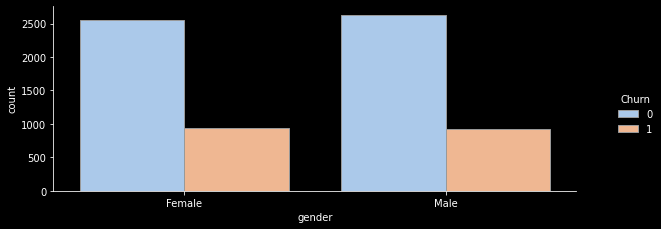

In [ ]:
# ▶ gender(성별)
sns.catplot(x="gender", hue="Churn", kind="count",palette="pastel", edgecolor=".6",data=df);
plt.gcf().set_size_inches(10, 3)


df_gp = df.groupby('gender')['Churn'].agg(['count','sum'])
df_gp['ratio'] = round((df_gp['sum'] / df_gp['count']) * 100, 1)
df_gp['lift'] = round(df_gp['ratio'] / ((df['Churn'].sum() / len(df))*100) ,1)
print(df_gp)

               count   sum  ratio  lift
SeniorCitizen                          
0               5901  1393   23.6   0.9
1               1142   476   41.7   1.6


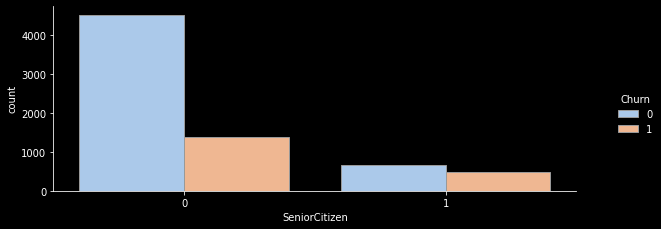

In [ ]:
# ▶ SeniorCitizen(노인가구여부)
sns.catplot(x="SeniorCitizen", hue="Churn", kind="count",palette="pastel", edgecolor=".6",data=df);
plt.gcf().set_size_inches(10, 3)


df_gp = df.groupby('SeniorCitizen')['Churn'].agg(['count','sum'])
df_gp['ratio'] = round((df_gp['sum'] / df_gp['count']) * 100, 1)
df_gp['lift'] = round(df_gp['ratio'] / ((df['Churn'].sum() / len(df))*100) ,1)
print(df_gp)

         count   sum  ratio  lift
Partner                          
No        3641  1200   33.0   1.2
Yes       3402   669   19.7   0.7


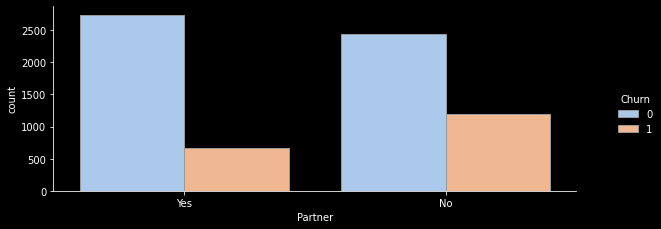

In [ ]:
# ▶ Partner(결혼여부)
sns.catplot(x="Partner", hue="Churn", kind="count",palette="pastel", edgecolor=".6",data=df);
plt.gcf().set_size_inches(10, 3)


df_gp = df.groupby('Partner')['Churn'].agg(['count','sum'])
df_gp['ratio'] = round((df_gp['sum'] / df_gp['count']) * 100, 1)
df_gp['lift'] = round(df_gp['ratio'] / ((df['Churn'].sum() / len(df))*100) ,1)
print(df_gp)

            count   sum  ratio  lift
Dependents                          
No           4933  1543   31.3   1.2
Yes          2110   326   15.5   0.6


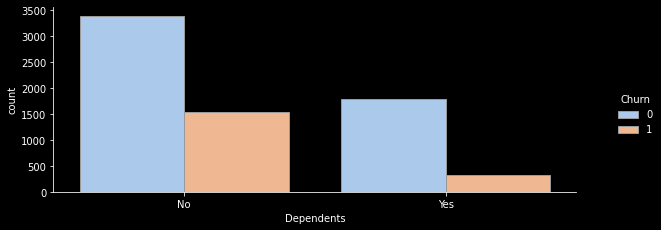

In [ ]:
# ▶ Dependents(부양가족 여부)
sns.catplot(x="Dependents", hue="Churn", kind="count",palette="pastel", edgecolor=".6",data=df);
plt.gcf().set_size_inches(10, 3)


df_gp = df.groupby('Dependents')['Churn'].agg(['count','sum'])
df_gp['ratio'] = round((df_gp['sum'] / df_gp['count']) * 100, 1)
df_gp['lift'] = round(df_gp['ratio'] / ((df['Churn'].sum() / len(df))*100) ,1)
print(df_gp)

### · 부가서비스 사용 - 이탈률 분석
---

In [ ]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_gp,MonthlyCharges_gp
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,20 이하,40 이하
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0,20-60 이하,40-80 이하
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,20 이하,40-80 이하
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,20-60 이하,40-80 이하
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,20 이하,40-80 이하


In [ ]:
# ▶ 부가서비스 col, 온락인백업서비스/기기보험서비스/기술지원서비스/스트리밍TV/스트리밍영화 서비스
df[['OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']]

,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,Yes,No,No,No,No
1,No,Yes,No,No,No
2,Yes,No,No,No,No
3,No,Yes,Yes,No,No
4,No,No,No,No,No
...,...,...,...,...,...
7038,No,Yes,Yes,Yes,Yes
7039,Yes,Yes,No,Yes,Yes
7040,No,No,No,No,No
7041,No,No,No,No,No


                     count   sum  ratio  lift
OnlineBackup                                 
No                    3088  1233   39.9   1.5
No internet service   1526   113    7.4   0.3
Yes                   2429   523   21.5   0.8


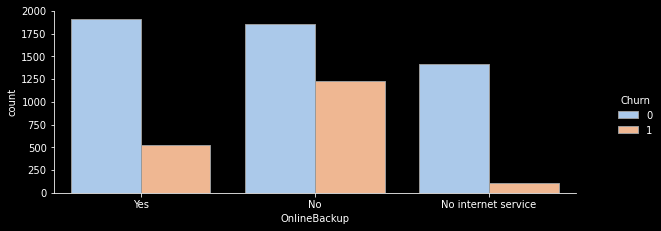

In [ ]:
# ▶ OnlineBackup(온라인 백업)	 
val = 'OnlineBackup'

sns.catplot(x=val, hue="Churn", kind="count",palette="pastel", edgecolor=".6",data=df);
plt.gcf().set_size_inches(10, 3)


df_gp = df.groupby(val)['Churn'].agg(['count','sum'])
df_gp['ratio'] = round((df_gp['sum'] / df_gp['count']) * 100, 1)
df_gp['lift'] = round(df_gp['ratio'] / ((df['Churn'].sum() / len(df))*100) ,1)
print(df_gp)

                     count   sum  ratio  lift
OnlineBackup                                 
No                    3088  1233   39.9   1.5
No internet service   1526   113    7.4   0.3
Yes                   2429   523   21.5   0.8
---------------------------------------
                     count   sum  ratio  lift
DeviceProtection                             
No                    3095  1211   39.1   1.5
No internet service   1526   113    7.4   0.3
Yes                   2422   545   22.5   0.8
---------------------------------------
                     count   sum  ratio  lift
TechSupport                                  
No                    3473  1446   41.6   1.6
No internet service   1526   113    7.4   0.3
Yes                   2044   310   15.2   0.6
---------------------------------------
                     count  sum  ratio  lift
StreamingTV                                 
No                    2810  942   33.5   1.3
No internet service   1526  113    7.4   0.3
Yes       

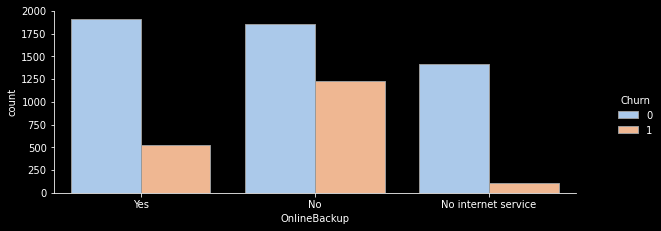

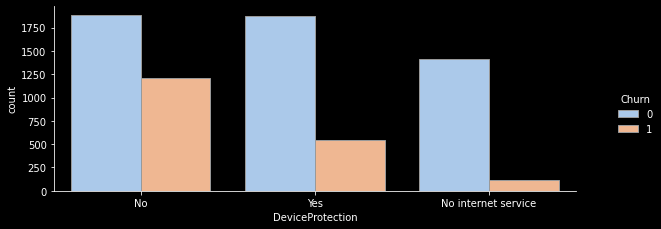

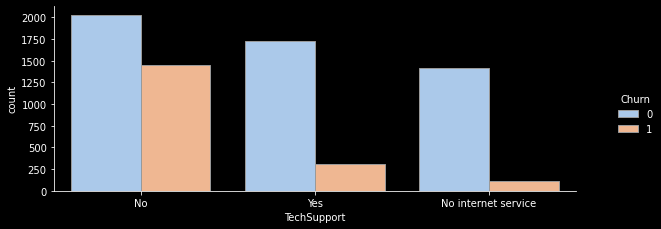

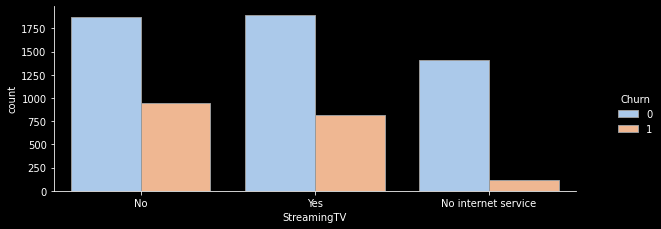

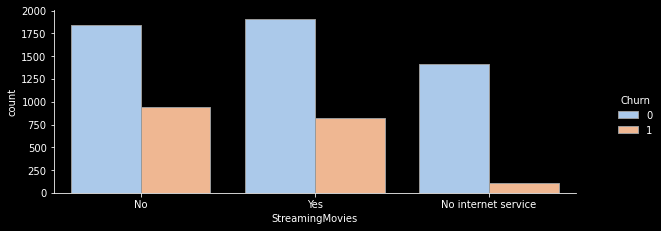

In [ ]:
# ▶ for문 활용 한 번에 출력

col_list = ['OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for i in col_list :
  val = i

  sns.catplot(x=val, hue="Churn", kind="count",palette="pastel", edgecolor=".6",data=df);
  plt.gcf().set_size_inches(10, 3)


  df_gp = df.groupby(val)['Churn'].agg(['count','sum'])
  df_gp['ratio'] = round((df_gp['sum'] / df_gp['count']) * 100, 1)
  df_gp['lift'] = round(df_gp['ratio'] / ((df['Churn'].sum() / len(df))*100) ,1)
  print(df_gp)
  print("---------------------------------------")

In [ ]:
# ▶ 부가서비시를 모두 이용하지 않는 고객에 이탈률 분석
df_no = df[(df['OnlineBackup'] =='No') & (df['DeviceProtection'] =='No') & (df['TechSupport'] =='No') & (df['StreamingTV'] =='No') & (df['StreamingMovies'] =='No')]
df_no[col_list]

,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4,No,No,No,No,No
7,No,No,No,No,No
10,No,No,No,No,No
34,No,No,No,No,No
36,No,No,No,No,No
...,...,...,...,...,...
7026,No,No,No,No,No
7032,No,No,No,No,No
7033,No,No,No,No,No
7040,No,No,No,No,No


In [ ]:
# ▶ 부가서비스 형태가 모두 No인고객은 47.6% 이탈률, Lift 약 1.8
df_no['Churn'].sum() / len(df_no)

0.4769585253456221

### · 계약 형태, 요금 - 이탈률 분석

---

In [ ]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_gp,MonthlyCharges_gp
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,20 이하,40 이하
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0,20-60 이하,40-80 이하
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,20 이하,40-80 이하
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,20-60 이하,40-80 이하
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,20 이하,40-80 이하


In [ ]:
# ▶ 계약형태 col, 계약기간/종이없는청구/결제수단
df[['Contract', 'PaperlessBilling', 'PaymentMethod']]

,Contract,PaperlessBilling,PaymentMethod
0,Month-to-month,Yes,Electronic check
1,One year,No,Mailed check
2,Month-to-month,Yes,Mailed check
3,One year,No,Bank transfer (automatic)
4,Month-to-month,Yes,Electronic check
...,...,...,...
7038,One year,Yes,Mailed check
7039,One year,Yes,Credit card (automatic)
7040,Month-to-month,Yes,Electronic check
7041,Month-to-month,Yes,Mailed check


In [ ]:
# ▶ for문 활용 한 번에 출력	 
col_list = ['Contract', 'PaperlessBilling', 'PaymentMethod']

for i in col_list :
  val = i

  df_gp = df.groupby(val)['Churn'].agg(['count','sum'])
  df_gp['ratio'] = round((df_gp['sum'] / df_gp['count']) * 100, 1)
  df_gp['lift'] = round(df_gp['ratio'] / ((df['Churn'].sum() / len(df))*100) ,1)
  print(df_gp)
  print("---------------------------------------------------")

                count   sum  ratio  lift
Contract                                
Month-to-month   3875  1655   42.7   1.6
One year         1473   166   11.3   0.4
Two year         1695    48    2.8   0.1
---------------------------------------------------
                  count   sum  ratio  lift
PaperlessBilling                          
No                 2872   469   16.3   0.6
Yes                4171  1400   33.6   1.3
---------------------------------------------------
                           count   sum  ratio  lift
PaymentMethod                                      
Bank transfer (automatic)   1544   258   16.7   0.6
Credit card (automatic)     1522   232   15.2   0.6
Electronic check            2365  1071   45.3   1.7
Mailed check                1612   308   19.1   0.7
---------------------------------------------------


## **🥇Session 3**  
**┗ ML 활용 이탈 고객 예측**  
---

### · 모델링을 위한 데이터 준비
---
* 모델링을 수행하기 위해 Feature와 예측하고자하는 값인 Y로 데이터를 나눔
* 학습과 예측을 위한 Train / Test set 분할

In [ ]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_gp,MonthlyCharges_gp
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,20 이하,40 이하
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0,20-60 이하,40-80 이하
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,20 이하,40-80 이하
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,20-60 이하,40-80 이하
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,20 이하,40-80 이하


In [ ]:
# ▶ numeric, categorical value 나누기
numeric_list=[]
categoical_list=[]

for i in df.columns :
  if df[i].dtypes == 'O' :
    categoical_list.append(i)
  else :
    numeric_list.append(i)

print("categoical_list :", categoical_list)
print("numeric_list :", numeric_list)

categoical_list : ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'tenure_gp', 'MonthlyCharges_gp']
numeric_list : ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'Churn']


In [ ]:
# ▶ 모델링을 학습하기 위한 Fearue(X)와 Y데이터를 구분하는 단계
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X=df.drop(['customerID', 'tenure_gp', 'MonthlyCharges_gp', 'Churn'], axis=1)
Y=df['Churn']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(4930, 19)
(4930,)
(2113, 19)
(2113,)


In [ ]:
categoical_list.remove('tenure_gp')
categoical_list.remove('MonthlyCharges_gp')
categoical_list.remove('customerID')

In [ ]:
from sklearn.preprocessing import LabelEncoder

for col in categoical_list:
    print(col)
    le = LabelEncoder()
    le.fit(list(x_train[col].values) + list(x_test[col].values))
    x_train[col] = le.transform(x_train[col])
    x_test[col] = le.transform(x_test[col])

gender
Partner
Dependents
PhoneService
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaperlessBilling
PaymentMethod
TotalCharges


### · 모델 학습 및 평가
---
* 모델을 학습하고 예측을 수행하여 성능을 평가

In [ ]:
from sklearn.metrics import classification_report
# ▶ 학습
rfc = RandomForestClassifier(random_state = 123456, max_depth=4, n_estimators=1000)
rfc.fit(x_train, y_train)

# ▶ 예측
y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.81      0.95      0.87      3622
           1       0.72      0.38      0.50      1308

    accuracy                           0.80      4930
   macro avg       0.77      0.67      0.69      4930
weighted avg       0.79      0.80      0.77      4930

              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1552
           1       0.74      0.34      0.46       561

    accuracy                           0.79      2113
   macro avg       0.77      0.65      0.67      2113
weighted avg       0.78      0.79      0.76      2113



In [ ]:
pd.Series(y_pred_test).value_counts()

0    1856
1     257
dtype: int64

In [ ]:
# ▶ 과적합 문제, Train과 Test set에 성능을 최대한 줄여주는 것이 과적합을 방지
from sklearn.metrics import roc_auc_score

y_pred_train_proba = rfc.predict_proba(x_train)[:, 1] 
y_pred_test_proba = rfc.predict_proba(x_test)[:, 1] 


roc_score_train = roc_auc_score(y_train, y_pred_train_proba)
roc_score_test = roc_auc_score(y_test, y_pred_test_proba)

print("roc_score_train :", roc_score_train)
print("roc_score_test :", roc_score_test)

roc_score_train : 0.8511600658226908
roc_score_test : 0.842709424444567


In [ ]:
from sklearn.metrics import roc_curve
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random', color='red')
  
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )')
    plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()

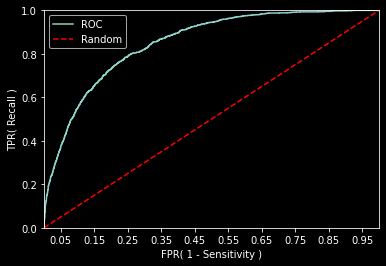

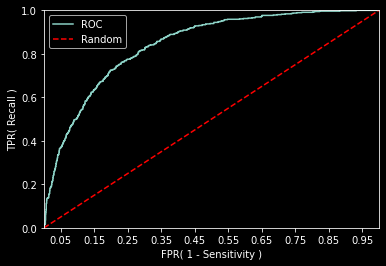

In [ ]:
roc_curve_plot(y_train, y_pred_train_proba)
roc_curve_plot(y_test, y_pred_test_proba)

### · 중요 변수 파악
---
* Feature IMP 분석을 통한 중요변수 파악


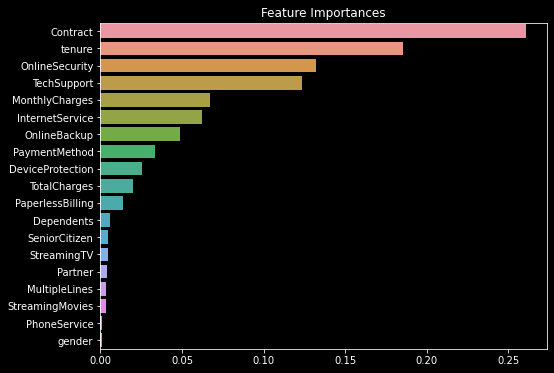

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

ftr_importances_values = rfc.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:31]

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
# plt.rc('xtick', labelsize=5)
plt.show()

                count   sum  ratio  lift
Contract                                
Month-to-month   3875  1655   42.7   1.6
One year         1473   166   11.3   0.4
Two year         1695    48    2.8   0.1


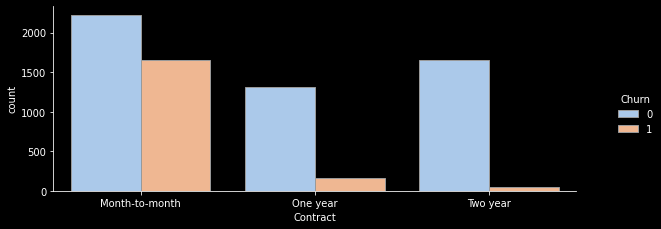

In [ ]:
# ▶ 1위 후보 변수 탐색
val = 'Contract'

sns.catplot(x=val, hue="Churn", kind="count",palette="pastel", edgecolor=".6",data=df);
plt.gcf().set_size_inches(10, 3)


df_gp = df.groupby(val)['Churn'].agg(['count','sum'])
df_gp['ratio'] = round((df_gp['sum'] / df_gp['count']) * 100, 1)
df_gp['lift'] = round(df_gp['ratio'] / ((df['Churn'].sum() / len(df))*100) ,1)
print(df_gp)


### · 모델 Save and Read
---
* 최종 모델을 저장 및 다시 불러오기

In [ ]:
import pickle
# 모델 저장
saved_model = pickle.dumps(rfc)

# 모델 Read
clf_from_pickle = pickle.loads(saved_model)